In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [3]:
df['price'] = df['price'].apply(np.log1p)

In [4]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,5.010635,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,5.420535,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,5.017280,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,4.499810,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,4.394449,10,9,0.10,1,0


In [5]:
df.fillna(0, inplace=True)

In [6]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=1)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [8]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [9]:
del df_train['price']
del df_val['price']
del df_test['price']

In [10]:
from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

### Question 1

In [14]:
from sklearn.tree import DecisionTreeRegressor

In [16]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [17]:
from sklearn.tree import export_text
print(export_text(dtr, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



room_type

### Question 2

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [31]:
y_pred = rf.predict(X_val)

In [32]:
from sklearn.metrics import mean_squared_error

In [37]:
round(mean_squared_error(y_val, y_pred, squared=False), 3)

0.462

### Question 3

In [40]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, n_jobs=-1, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = round(mean_squared_error(y_val, y_pred, squared=False), 3)
    scores.append((n, rmse))

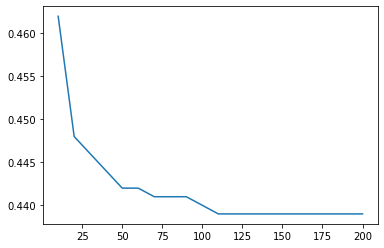

In [41]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

120

In [42]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, 
                                   max_depth=d,
                                   n_jobs=-1, 
                                   random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = round(mean_squared_error(y_val, y_pred, squared=False), 3)
        scores.append((d, n, rmse))


In [43]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

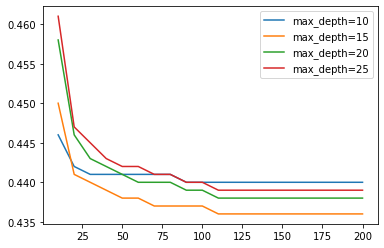

In [44]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth={d}')

plt.legend()

15

### Question 5

In [51]:
rf = RandomForestRegressor(n_estimators=10, 
                           max_depth=20,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

In [52]:
dv.get_feature_names()[np.argmax(rf.feature_importances_)]

'room_type=Entire home/apt'

### Question 6

In [56]:
import xgboost as xgb

In [61]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [57]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [58]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [68]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6, 
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [63]:
df_scores_03 = parse_xgb_output(output)

In [67]:
df_scores_01 = parse_xgb_output(output)

In [69]:
df_scores_001 = parse_xgb_output(output)

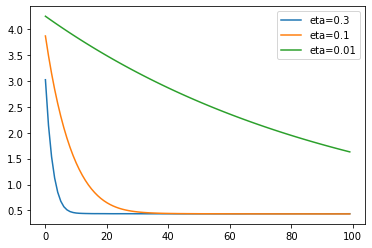

In [70]:
plt.plot(df_scores_03.num_iter, df_scores_03.val_auc, label='eta=0.3')
plt.plot(df_scores_01.num_iter, df_scores_01.val_auc, label='eta=0.1')
plt.plot(df_scores_001.num_iter, df_scores_001.val_auc, label='eta=0.01')

plt.legend()

0.1

In [73]:
min(df_scores_03.val_auc)

0.43371

In [74]:
min(df_scores_01.val_auc)

0.4325

In [75]:
min(df_scores_001.val_auc)

1.63045